---
syncID: 3857005e98a544a88a5e58625e32b514
title: "Introduction to working with NEON eddy flux data"
description: "Download and navigate NEON eddy flux data, including basic transformations and merges"
dateCreated:  2019-07-09
authors: Claire K. Lunch
contributors: 
estimatedTime: 1 hour
packagesLibraries: rhdf5, neonUtilities, ggplot2
topics: HDF5, eddy-covariance, eddy-flux
languagesTool: R
dataProduct: DP4.00200.001
code1: /R/eddy-intro/eddy_intro.r
tutorialSeries: 
urlTitle: eddy-data-intro
---

This data tutorial provides an introduction to working with NEON eddy 
flux data, using the `neonUtilities` R package. If you are new to NEON 
data, we recommend starting with a more general tutorial, such as the 
<a href="https://www.neonscience.org/neonDataStackR" target="_blank">neonUtilities tutorial</a> 
or the <a href="https://www.neonscience.org/download-explore-neon-data" target="_blank">Download and Explore tutorial</a>. 
Some of the functions and techniques described in those tutorials will 
be used here, as well as functions and data formats that are unique to 
the eddy flux system.

This tutorial assumes general familiarity with eddy flux data and 
associated concepts.

## 1. Setup

Start by installing and loading packages and setting options. 
To work with the NEON flux data, we need the `rhdf5` package, 
which is hosted on Bioconductor, and requires a different 
installation process than CRAN packages:

In [ ]:
install.packages('BiocManager')
BiocManager::install('rhdf5')
install.packages('neonUtilities')

In [1]:
options(stringsAsFactors=F)

library(neonUtilities)

Use the `zipsByProduct()` function from the `neonUtilities` package to 
download flux data from two sites and two months. The transformations 
and functions below will work on any time range and site(s), but two 
sites and two months allows us to see all the available functionality 
while minimizing download size.

Inputs to the `zipsByProduct()` function:

* `dpID`: DP4.00200.001, the bundled eddy covariance product
* `package`: basic (the expanded package is not covered in this tutorial)
* `site`: NIWO = Niwot Ridge and HARV = Harvard Forest
* `startdate`: 2018-06 (both dates are inclusive)
* `enddate`: 2018-07 (both dates are inclusive)
* `savepath`: modify this to something logical on your machine
* `check.size`: T if you want to see file size before downloading, otherwise F

The download may take a while, especially if you're on a slow network.

In [2]:
zipsByProduct(dpID="DP4.00200.001", package="basic", 
              site=c("NIWO", "HARV"), 
              startdate="2018-06", enddate="2018-07",
              savepath="/data", 
              check.size=F)

  |======================================================================| 100%
4 files downloaded to /data/filesToStack00200


## 2. Data Levels

There are five levels of data contained in the eddy flux bundle. For full 
details, refer to the <a href="http://data.neonscience.org/api/v0/documents/NEON.DOC.004571vA" target="_blank">NEON algorithm document</a>.

Briefly, the data levels are:

* Level 0' (dp0p): Calibrated raw observations
* Level 1 (dp01): Time-aggregated observations, e.g. 30-minute mean gas concentrations
* Level 2 (dp02): Time-interpolated data, e.g. rate of change of a gas concentration
* Level 3 (dp03): Spatially interpolated data, i.e. vertical profiles
* Level 4 (dp04): Fluxes

The dp0p data are available in the expanded data package and are beyond 
the scope of this tutorial.

The dp02 and dp03 data are used in storage calculations, and the dp04 data 
include both the storage and turbulent components. Since many users will 
want to focus on the net flux data, we'll start there.

## 3. Extract Level 4 data (Fluxes!)

To extract the Level 4 data from the HDF5 files and merge them into a 
single table, we'll use the `stackEddy()` function from the `neonUtilities` 
package.

`stackEddy()` requires two inputs:

* `filepath`: Path to a file or folder, which can be any one of:
    1. A zip file of eddy flux data downloaded from the NEON data portal
    2. A folder of eddy flux data downloaded by the `zipsByProduct()` function
    3. The folder of files resulting from unzipping either of 1 or 2
    4. A single HDF5 file of NEON eddy flux data
* `level`: dp01-4

Input the filepath you downloaded to using `zipsByProduct()` earlier, 
including the `filestoStack00200` folder created by the function, and 
`dp04`:

In [3]:
flux <- stackEddy(filepath="/data/filesToStack00200/",
                 level="dp04")

Extracting data
  |======================================================================| 100%
Stacking data tables by month
  |======================================================================| 100%
Joining data variables
  |======================================================================| 100%


We now have an object called `flux`. It's a named list containing four 
tables: one table for each site's data, and `variables` and `objDesc` 
tables.

In [4]:
names(flux)

[1] "HARV"      "NIWO"      "variables" "objDesc"

Let's look at the contents of one of the site data files:

In [5]:
head(flux$NIWO)

,timeBgn,timeEnd,data.fluxCo2.nsae.flux,data.fluxCo2.stor.flux,data.fluxCo2.turb.flux,data.fluxH2o.nsae.flux,data.fluxH2o.stor.flux,data.fluxH2o.turb.flux,data.fluxMome.turb.veloFric,data.fluxTemp.nsae.flux,⋯,data.foot.stat.veloFric,data.foot.stat.distZaxsMeasDisp,data.foot.stat.distZaxsRgh,data.foot.stat.distZaxsAbl,data.foot.stat.distXaxs90,data.foot.stat.distXaxsMax,data.foot.stat.distYaxs90,qfqm.fluxCo2.stor.qfFinl,qfqm.fluxH2o.stor.qfFinl,qfqm.fluxTemp.stor.qfFinl
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,2018-06-01T00:00:00.000Z,2018-06-01T00:29:59.000Z,0.1111935,-0.06191186,0.1731053,19.401824,3.2511265,16.150697,0.19707045,4.1712006,⋯,0.2,8.34,0.03221479,1000,333.60,133.44,25.02,1,1,0
2,2018-06-01T00:30:00.000Z,2018-06-01T00:59:59.000Z,0.9328922,0.08534117,0.8475510,10.444936,-1.1768333,11.621770,0.19699723,-0.9163691,⋯,0.2,8.34,0.33007082,1000,258.54,108.42,50.04,1,1,0
3,2018-06-01T01:00:00.000Z,2018-06-01T01:29:59.000Z,0.4673682,0.02177216,0.4455960,5.140617,-4.3112673,9.451884,0.06518208,-2.9814957,⋯,0.2,8.34,0.12876068,1000,308.58,125.10,58.38,1,1,0
4,2018-06-01T01:30:00.000Z,2018-06-01T01:59:59.000Z,0.7263614,0.24944366,0.4769178,9.017467,0.1980776,8.819389,0.12964000,-13.3556222,⋯,0.2,8.34,0.83400000,1000,208.50,83.40,75.06,1,1,0
5,2018-06-01T02:00:00.000Z,2018-06-01T02:29:59.000Z,0.4740572,0.22524363,0.2488136,3.180386,0.1316297,3.048756,0.17460706,-5.3406503,⋯,0.2,8.34,0.83400000,1000,208.50,83.40,66.72,1,1,0
6,2018-06-01T02:30:00.000Z,2018-06-01T02:59:59.000Z,0.8807022,0.07078007,0.8099221,4.398761,-0.2989443,4.697706,0.10477970,-7.2739206,⋯,0.2,8.34,0.83400000,1000,208.50,83.40,41.70,1,1,0


The `variables` and `objDesc` tables can help you interpret the column 
headers in the data table. The `objDesc` table contains definitions for 
many of the terms used in the eddy flux data product, but it isn't 
complete. To get the terms of interest, we'll break up the column headers 
into individual terms and look for them in the `objDesc` table:

In [6]:
term <- unlist(strsplit(names(flux$NIWO), split=".", fixed=T))
flux$objDesc[which(flux$objDesc$Object %in% term),]

,Object,Description
,<chr>,<chr>
138,angZaxsErth,Wind direction
171,data,Represents data fields
343,qfFinl,"The final quality flag indicating if the data are valid for the given aggregation period (1=fail, 0=pass)"
420,qfqm,"Quality flag and quality metrics, represents quality flags and quality metrics that accompany the provided data"
604,timeBgn,The beginning time of the aggregation period
605,timeEnd,The end time of the aggregation period


For the terms that aren't captured here, `fluxCo2`, `fluxH2o`, and `fluxTemp` 
are self-explanatory. The flux components are

* `turb`: Turbulent flux
* `stor`: Storage
* `nsae`: Net surface-atmosphere exchange

The `variables` table contains the units for each field:

In [7]:
flux$variables

,category,system,variable,stat,units
,<chr>,<chr>,<chr>,<chr>,<chr>
1,data,fluxCo2,nsae,,umolCo2 m-2 s-1
2,data,fluxCo2,stor,,umolCo2 m-2 s-1
3,data,fluxCo2,turb,,umolCo2 m-2 s-1
4,data,fluxH2o,nsae,,W m-2
5,data,fluxH2o,stor,,W m-2
6,data,fluxH2o,turb,,W m-2
7,data,fluxMome,turb,,m s-1
8,data,fluxTemp,nsae,,W m-2
9,data,fluxTemp,stor,,W m-2


Let's plot some data! First, we'll need to convert the time stamps 
to an R date-time format (right now they're just character fields).

### Time stamps

NEON sensor data come with time stamps for both the start and end of 
the averaging period. Depending on the analysis you're doing, you may 
want to use one or the other; for general plotting, re-formatting, and 
transformations, I prefer to use the start time, because there 
are some small inconsistencies between data products in a few of the 
end time stamps.

Note that **all** NEON data use UTC time, noted as 
`tz="GMT"` in the code below. This is true across NEON's instrumented, 
observational, and airborne measurements. When working with NEON data, 
it's best to keep everything in UTC as much as possible, otherwise it's 
very easy to end up with data in mismatched times, which can cause 
insidious and hard-to-detect problems. Be sure to include the `tz` 
argument in all the lines of code below - if there is no time zone 
specified, R will default to the local time zone it detects on your 
operating system.

In [8]:
timeB <- as.POSIXct(flux$NIWO$timeBgn, 
                    format="%Y-%m-%dT%H:%M:%S", 
                    tz="GMT")
flux$NIWO <- cbind(timeB, flux$NIWO)

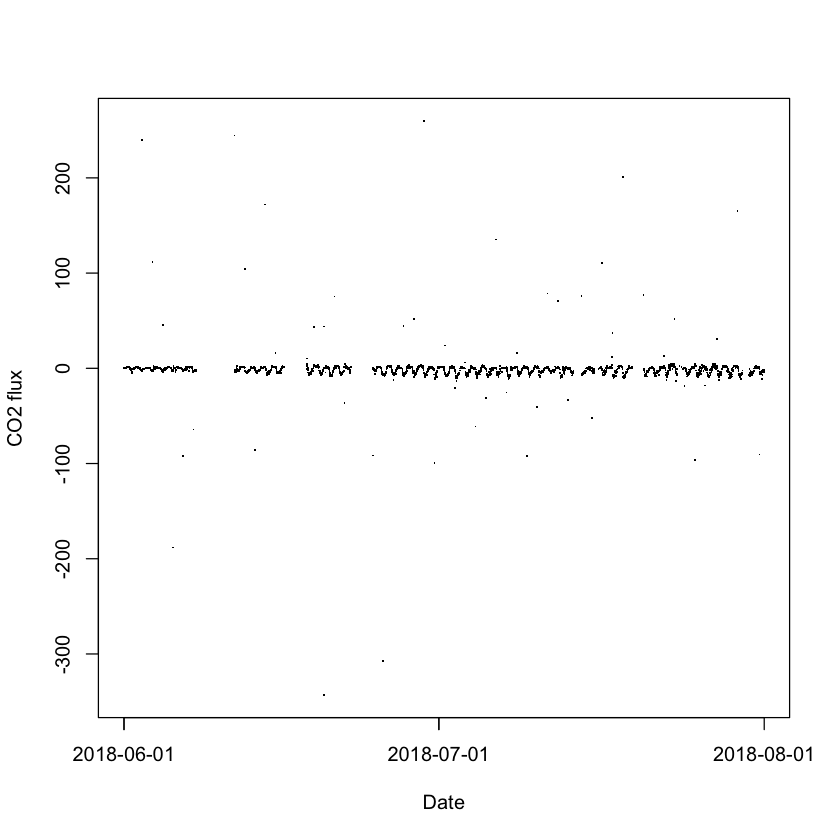

In [9]:
plot(flux$NIWO$data.fluxCo2.nsae.flux~timeB, 
     pch=".", xlab="Date", ylab="CO2 flux",
     xaxt="n")
axis.POSIXct(1, x=timeB, format="%Y-%m-%d")

Like a lot of flux data, these data have some stray spikes, but there 
is a clear diurnal pattern going into the growing season.

Let's trim down to just two days of data to see a few other details.

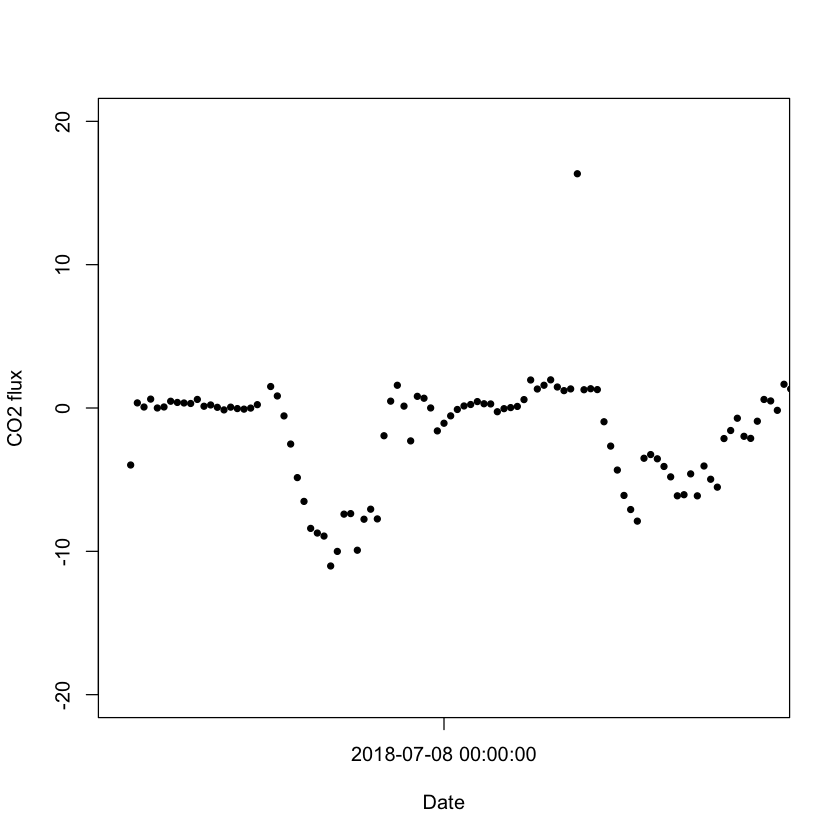

In [10]:
plot(flux$NIWO$data.fluxCo2.nsae.flux~timeB, 
     pch=20, xlab="Date", ylab="CO2 flux",
     xlim=c(as.POSIXct("2018-07-07", tz="GMT"),
            as.POSIXct("2018-07-09", tz="GMT")),
    ylim=c(-20,20), xaxt="n")
axis.POSIXct(1, x=timeB, format="%Y-%m-%d %H:%M:%S")

Note the timing of C uptake; the UTC time zone is clear here, where 
uptake occurs at times that appear to be during the night.

## 4. Merge flux data with other sensor data

Many of the data sets we would use to interpret and model flux data are 
measured as part of the NEON project, but are not present in the eddy flux 
data product bundle. In this section, we'll download PAR data and merge 
them with the flux data; the steps taken here can be applied to any of the 
NEON instrumented (IS) data products.

### Download PAR data

To get NEON PAR data, use the `loadByProduct()` function from the 
`neonUtilities` package. `loadByProduct()` takes the same inputs as 
`zipsByProduct()`, but it loads the downloaded data directly into the 
current R environment.

Let's download PAR data matching the Niwot Ridge flux data. The inputs 
needed are:

* `dpID`: DP1.00024.001
* `site`: NIWO
* `startdate`: 2018-06
* `enddate`: 2018-07
* `package`: basic
* `avg`: 30

The new input here is `avg=30`, which downloads only the 30-minute data. 
Since the flux data are at a 30-minute resolution, we can save on 
download time by disregarding the 1-minute data files (which are of course 
30 times larger). The `avg` input can be left off if you want to download 
all available averaging intervals.

In [11]:
pr <- loadByProduct("DP1.00024.001", site="NIWO", avg=30,
                    startdate="2018-06", enddate="2018-07",
                    package="basic", check.size=F)

  |======================================================================| 100%

Stacking operation across a single core.
Stacking table PARPAR_30min
Merged the most recent publication of sensor position files for each site and saved to /stackedFiles
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 1 data tables and 2 metadata tables!
Stacking took 0.2982938 secs


`pr` is another named list, and again, metadata and units can be found in 
the `variables` table. The `PARPAR_30min` table contains a `verticalPosition` 
field. This field indicates the position on the tower, with 10 being the 
first tower level, and 20, 30, etc going up the tower.

### Join PAR to flux data

We'll connect PAR data from the tower top to the flux data.

In [12]:
pr.top <- pr$PARPAR_30min[which(pr$PARPAR_30min$verticalPosition==
                                max(pr$PARPAR_30min$verticalPosition)),]

`loadByProduct()` automatically converts time stamps when it reads the 
data, so here we just need to indicate which time field to use to 
merge the flux and PAR data.

In [13]:
timeB <- pr.top$startDateTime
pr.top <- cbind(timeB, pr.top)

And merge the two datasets:

In [14]:
fx.pr <- merge(pr.top, flux$NIWO, by="timeB")

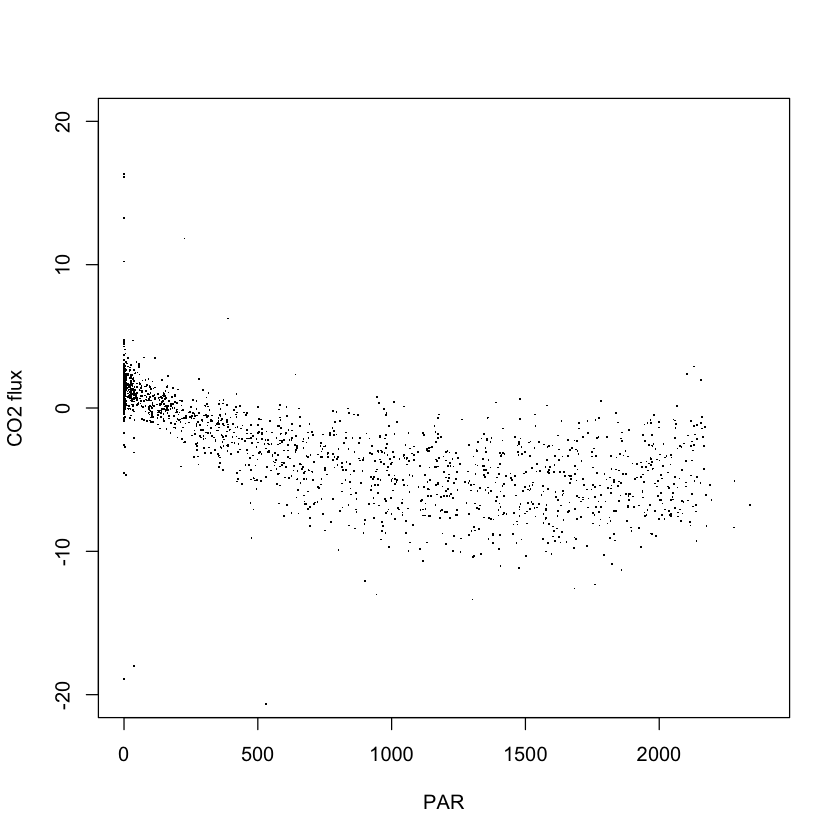

In [15]:
plot(fx.pr$data.fluxCo2.nsae.flux~fx.pr$PARMean,
     pch=".", ylim=c(-20,20),
     xlab="PAR", ylab="CO2 flux")

If you're interested in data in the eddy covariance bundle besides the 
net flux data, the rest of this tutorial will guide you through how to 
get those data out of the bundle.

## 5. Vertical profile data (Level 3)

The Level 3 (`dp03`) data are the spatially interpolated profiles of 
the rates of change of CO<sub>2</sub>, H<sub>2</sub>O, and temperature.
Extract the Level 3 data from the HDF5 file using `stackEddy()` with 
the same syntax as for the Level 4 data.

In [16]:
prof <- stackEddy(filepath="/data/filesToStack00200/",
                 level="dp03")

Extracting data
  |======================================================================| 100%
Stacking data tables by month
  |======================================================================| 100%
Joining data variables
  |======================================================================| 100%


In [17]:
head(prof$NIWO)

,timeBgn,timeEnd,data.co2Stor.rateRtioMoleDryCo2.0.1 m,data.co2Stor.rateRtioMoleDryCo2.0.2 m,data.co2Stor.rateRtioMoleDryCo2.0.3 m,data.co2Stor.rateRtioMoleDryCo2.0.4 m,data.co2Stor.rateRtioMoleDryCo2.0.5 m,data.co2Stor.rateRtioMoleDryCo2.0.6 m,data.co2Stor.rateRtioMoleDryCo2.0.7 m,data.co2Stor.rateRtioMoleDryCo2.0.8 m,⋯,qfqm.tempStor.rateTemp.7.5 m,qfqm.tempStor.rateTemp.7.6 m,qfqm.tempStor.rateTemp.7.7 m,qfqm.tempStor.rateTemp.7.8 m,qfqm.tempStor.rateTemp.7.9 m,qfqm.tempStor.rateTemp.8 m,qfqm.tempStor.rateTemp.8.1 m,qfqm.tempStor.rateTemp.8.2 m,qfqm.tempStor.rateTemp.8.3 m,qfqm.tempStor.rateTemp.8.4 m
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2018-06-01T00:00:00.000Z,2018-06-01T00:29:59.000Z,-0.0002681938,-0.0002681938,-0.0002681938,-0.0002681938,-0.0002681938,-0.0002681938,-0.0002681938,-0.0002681938,⋯,0,0,0,0,0,0,0,0,0,0
2,2018-06-01T00:30:00.000Z,2018-06-01T00:59:59.000Z,0.0004878799,0.0004878799,0.0004878799,0.0004878799,0.0004878799,0.0004673503,0.0004331343,0.0003989183,⋯,0,0,0,0,0,0,0,0,0,0
3,2018-06-01T01:00:00.000Z,2018-06-01T01:29:59.000Z,0.0005085725,0.0005085725,0.0005085725,0.0005085725,0.0005085725,0.0005025472,0.0004925052,0.0004824631,⋯,0,0,0,0,0,0,0,0,0,0
4,2018-06-01T01:30:00.000Z,2018-06-01T01:59:59.000Z,0.0013276966,0.0013276966,0.0013276966,0.0013276966,0.0013276966,0.0013735225,0.0014498989,0.0015262753,⋯,0,0,0,0,0,0,0,0,0,0
5,2018-06-01T02:00:00.000Z,2018-06-01T02:29:59.000Z,0.0007344040,0.0007344040,0.0007344040,0.0007344040,0.0007344040,0.0008510161,0.0010453695,0.0012397230,⋯,0,0,0,0,0,0,0,0,0,0
6,2018-06-01T02:30:00.000Z,2018-06-01T02:59:59.000Z,-0.0009449785,-0.0009449785,-0.0009449785,-0.0009449785,-0.0009449785,-0.0007653319,-0.0004659209,-0.0001665099,⋯,0,0,0,0,0,0,0,0,0,0


## 6. Un-interpolated vertical profile data (Level 2)

The Level 2 data are interpolated in time but not in space. They 
contain the rates of change at the measurement heights.

Again, they can be extracted from the HDF5 files using `stackEddy()` 
with the same syntax:

In [18]:
prof.l2 <- stackEddy(filepath="/data/filesToStack00200/",
                 level="dp02")

Extracting data
  |======================================================================| 100%
Stacking data tables by month
  |======================================================================| 100%
Joining data variables
  |======================================================================| 100%


In [19]:
head(prof.l2$HARV)

,verticalPosition,timeBgn,timeEnd,data.co2Stor.rateRtioMoleDryCo2.mean,data.h2oStor.rateRtioMoleDryH2o.mean,data.tempStor.rateTemp.mean,qfqm.co2Stor.rateRtioMoleDryCo2.qfFinl,qfqm.h2oStor.rateRtioMoleDryH2o.qfFinl,qfqm.tempStor.rateTemp.qfFinl
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,010,2018-06-01T00:00:00.000Z,2018-06-01T00:29:59.000Z,NaN,NaN,2.583333e-05,1,1,0
2,010,2018-06-01T00:30:00.000Z,2018-06-01T00:59:59.000Z,0.002194788,NaN,-2.008056e-04,1,1,0
3,010,2018-06-01T01:00:00.000Z,2018-06-01T01:29:59.000Z,-0.010752434,NaN,-1.901111e-04,1,1,0
4,010,2018-06-01T01:30:00.000Z,2018-06-01T01:59:59.000Z,0.002556148,NaN,-7.419444e-05,1,1,0
5,010,2018-06-01T02:00:00.000Z,2018-06-01T02:29:59.000Z,-0.015977747,NaN,-1.537083e-04,1,1,0
6,010,2018-06-01T02:30:00.000Z,2018-06-01T02:59:59.000Z,-0.000537461,NaN,-1.874861e-04,1,1,0


Note that here, as in the PAR data, there is a `verticalPosition` field. 
It has the same meaning as in the PAR data, indicating the tower level of 
the measurement.

## 7. Calibrated raw data (Level 1)

Level 1 (`dp01`) data are calibrated, and aggregated in time, but 
otherwise untransformed. Use Level 1 data for raw gas 
concentrations and atmospheric stable isotopes.

Using `stackEddy()` to extract Level 1 data requires additional 
inputs. The Level 1 files are too large to simply pull out all the 
variables by default, and they include mutiple averaging intervals, 
which can't be merged. So two additional inputs are needed:

* `avg`: The averaging interval to extract
* `var`: One or more variables to extract

What variables are available, at what averaging intervals? Another 
function in the `neonUtilities` package, `getVarsEddy()`, returns 
a list of HDF5 file contents. It requires only one input, a filepath 
to a single NEON HDF5 file:

In [20]:
vars <- getVarsEddy("/data/filesToStack00200/NEON.D01.HARV.DP4.00200.001.nsae.2018-07.basic.h5")
head(vars)

,site,level,category,system,hor,ver,tmi,name,otype,dclass,dim,oth
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
5,HARV,dp01,data,amrs,000,060,01m,angNedXaxs,H5I_DATASET,COMPOUND,44640,NA
6,HARV,dp01,data,amrs,000,060,01m,angNedYaxs,H5I_DATASET,COMPOUND,44640,NA
7,HARV,dp01,data,amrs,000,060,01m,angNedZaxs,H5I_DATASET,COMPOUND,44640,NA
9,HARV,dp01,data,amrs,000,060,30m,angNedXaxs,H5I_DATASET,COMPOUND,1488,NA
10,HARV,dp01,data,amrs,000,060,30m,angNedYaxs,H5I_DATASET,COMPOUND,1488,NA
11,HARV,dp01,data,amrs,000,060,30m,angNedZaxs,H5I_DATASET,COMPOUND,1488,NA


Inputs to `var` can be any values from the `name` field in the table 
returned by `getVarsEddy()`. Let's take a look at CO<sub>2</sub> and 
H<sub>2</sub>O, <sup>13</sup>C in CO<sub>2</sub> and <sup>18</sup>O in 
H<sub>2</sub>O, at 30-minute aggregation. Let's look at Harvard Forest 
for these data, since deeper canopies generally have more interesting 
profiles:

In [21]:
iso <- stackEddy(filepath="/data/filesToStack00200/",
               level="dp01", var=c("rtioMoleDryCo2","rtioMoleDryH2o",
                                   "dlta13CCo2","dlta18OH2o"), avg=30)

Extracting data
  |======================================================================| 100%
Stacking data tables by month
  |======================================================================| 100%
Joining data variables
  |======================================================================| 100%


In [22]:
head(iso$HARV)

,verticalPosition,timeBgn,timeEnd,data.co2Stor.rtioMoleDryCo2.mean,data.co2Stor.rtioMoleDryCo2.min,data.co2Stor.rtioMoleDryCo2.max,data.co2Stor.rtioMoleDryCo2.vari,data.co2Stor.rtioMoleDryCo2.numSamp,data.co2Turb.rtioMoleDryCo2.mean,data.co2Turb.rtioMoleDryCo2.min,⋯,ucrt.isoCo2.rtioMoleDryCo2.se,ucrt.isoCo2.rtioMoleDryH2o.mean,ucrt.isoCo2.rtioMoleDryH2o.vari,ucrt.isoCo2.rtioMoleDryH2o.se,ucrt.isoH2o.dlta18OH2o.mean,ucrt.isoH2o.dlta18OH2o.vari,ucrt.isoH2o.dlta18OH2o.se,ucrt.isoH2o.rtioMoleDryH2o.mean,ucrt.isoH2o.rtioMoleDryH2o.vari,ucrt.isoH2o.rtioMoleDryH2o.se
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,010,2018-06-01T00:00:00.000Z,2018-06-01T00:29:59.000Z,509.3375,451.4786,579.3518,845.0795,235,NA,NA,⋯,NA,NaN,NaN,NA,NaN,NaN,NA,NaN,NaN,NA
2,010,2018-06-01T00:30:00.000Z,2018-06-01T00:59:59.000Z,502.2736,463.5470,533.6622,161.3652,175,NA,NA,⋯,1.764965,0.08848440,0.01226428,0.014335993,0.02544454,0.003017400,0.008116413,0.06937514,0.009640249,0.006855142
3,010,2018-06-01T01:00:00.000Z,2018-06-01T01:29:59.000Z,521.6139,442.8649,563.0518,547.9924,235,NA,NA,⋯,NA,NaN,NaN,NA,NaN,NaN,NA,NaN,NaN,NA
4,010,2018-06-01T01:30:00.000Z,2018-06-01T01:59:59.000Z,469.6317,432.6588,508.7463,396.8379,175,NA,NA,⋯,1.149078,0.08917388,0.01542679,0.017683602,0.01373503,0.002704220,0.008582764,0.08489408,0.008572288,0.005710986
5,010,2018-06-01T02:00:00.000Z,2018-06-01T02:29:59.000Z,484.7725,436.2842,537.4641,662.9449,235,NA,NA,⋯,NA,NaN,NaN,NA,NaN,NaN,NA,NaN,NaN,NA
6,010,2018-06-01T02:30:00.000Z,2018-06-01T02:59:59.000Z,476.8554,443.7055,515.6598,246.6969,175,NA,NA,⋯,0.670111,NA,NA,0.005890447,0.01932110,0.002095066,0.008049170,0.02813808,0.002551672,0.002654748


Let's plot vertical profiles of CO<sub>2</sub> and <sup>13</sup>C in CO<sub>2</sub> 
on a single day. 

Here, for convenience, instead of converting the time stamps 
to a time format, it's easy to use the character format to extract the ones 
we want using `grep()`. And discard the `verticalPosition` values that are 
string values - those are the calibration gases.

In [23]:
iso.d <- iso$HARV[grep("2018-06-25", iso$HARV$timeBgn, fixed=T),]
iso.d <- iso.d[-which(is.na(as.numeric(iso.d$verticalPosition))),]

Warning message in which(is.na(as.numeric(iso.d$verticalPosition))):
“NAs introduced by coercion”


`ggplot` is well suited to these types of data, let's use it to plot 
the profiles.

In [24]:
library(ggplot2)

Warning message:
“Removed 2 rows containing missing values (geom_path).”


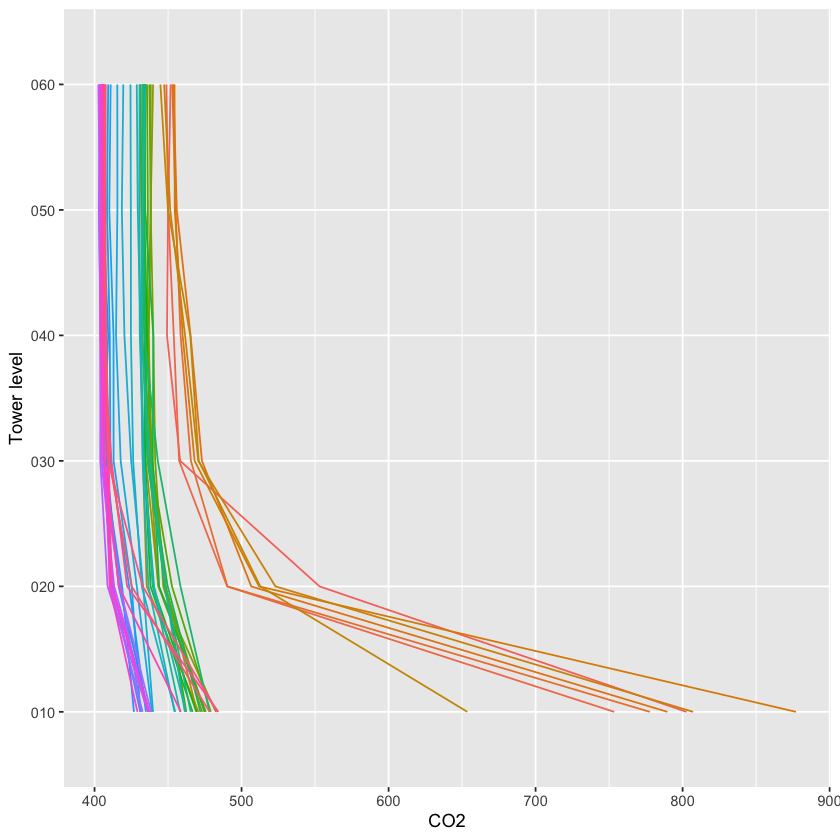

In [25]:
g <- ggplot(iso.d, aes(y=verticalPosition)) + 
  geom_path(aes(x=data.co2Stor.rtioMoleDryCo2.mean, 
                group=timeBgn, col=timeBgn)) + 
  theme(legend.position="none") + 
  xlab("CO2") + ylab("Tower level")
g

Warning message:
“Removed 55 rows containing missing values (geom_path).”


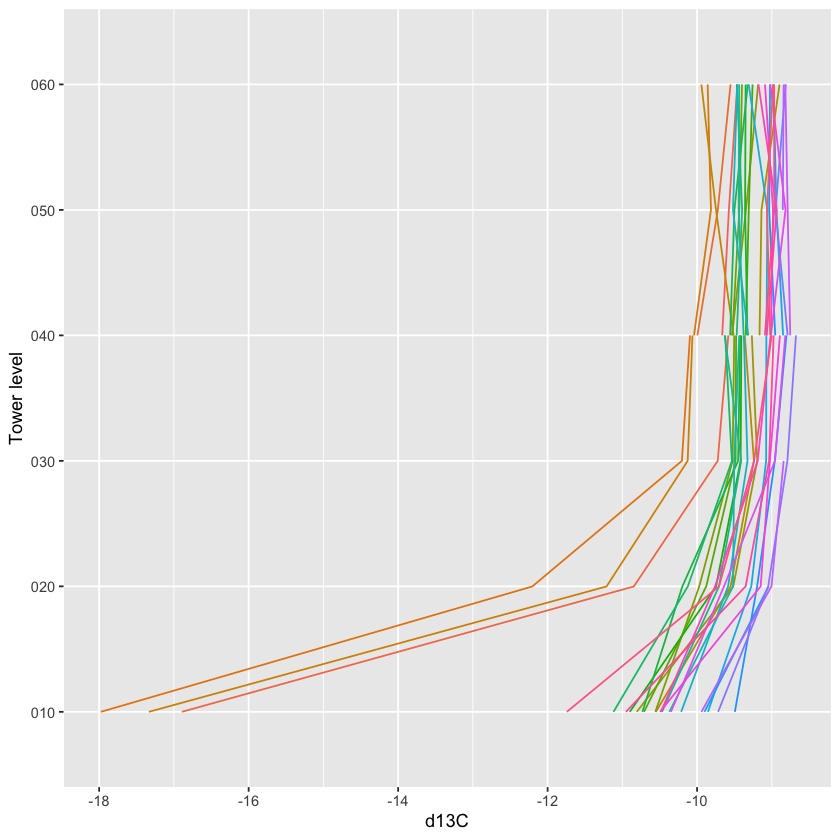

In [26]:
g <- ggplot(iso.d, aes(y=verticalPosition)) + 
  geom_path(aes(x=data.isoCo2.dlta13CCo2.mean, 
                group=timeBgn, col=timeBgn)) + 
  theme(legend.position="none") + 
  xlab("d13C") + ylab("Tower level")
g

The legends are omitted for space, see if you can work out the times 
of day the different colors represent.